Anggota Kelompok


*   Mochammad Azizil Akbar (202110370311284)
*   Muhammad Hadi Nur Fakhri (202110370311255)

kelas Pemrosesan Bahasa Alami D



### import library yang digunakan

In [ ]:
!pip install Sastrawi

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 209.7/209.7 kB 4.6 MB/s eta 0:00:00


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')
import re

from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from collections import Counter
from nltk.util import ngrams
from gensim.models import FastText, Word2Vec
from nltk.stem import PorterStemmer, WordNetLemmatizer
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


### acquire data

data diperoleh dari proses twitter crawling yang mengambil 1500 data. kemudian data dipilih 300 data dengan 3 kelas yaitu negatif, positif, dan netral masing-masing 100 data.

In [ ]:
data = pd.read_csv("NLP_202110370311284_Dataset.csv")
data

,fulltext,sentimen
0,@WatchmenID Ada gak sih film horor indo yg set...,negatif
1,ph indo kalo gabikin film horor kejang kh demi...,negatif
2,film indo kalo ga horor bawa bawa agama poliga...,negatif
3,bacot bgt film indo horor mulu terus pemainnya...,negatif
4,ini film ga cocok buat jadi horor maksa bgt an...,negatif
...,...,...
295,siksa kubur sukses bikin horror terbaik tahun ...,Positif
296,#PamaliDusunPocong ngeri banget satu dusun jad...,Positif
297,sumpahnya makin kagum film horor yg dia bikin ...,Positif
298,Emang kalo udah disutradarai @non_hadrah dan d...,Positif


In [ ]:
# Memastikan tidak ada data yang kosong
print(data.isna().sum())
data = data.dropna()

fulltext    0
sentimen    0
dtype: int64


In [ ]:
# Menampilkan dimensi dari dataset
data.shape

(300, 2)

### proprocessing


#### data cleaning

In [ ]:
# untuk menghilangkan simbol-simbol dan angka
def prepro(data):
  data = re.sub(r'@\w+', '',data)                                # Menghapus Username
  data = re.sub('https?:\/\/\S+', '',data)                       # Menghapus Link
  data = re.sub('[^a-zA-Z]', ' ', str(data).lower().strip())      # Lower Case setiap kata
  data = re.sub('#','',data)                                      # Hanya menghapus simbol hastag
  data = re.sub('\d+', '',data)                                  # Menghapus angka
  data = re.sub('[!"#$%&\()*+,-./:;<=>?@[\\]^_`{|}~]+','',data)  # Menghapus simbol-simbol beserta string selanjutnya
  data = re.sub('RT[\s]+','',data)                                # Menghapus kata yang memiliki "retweet / RT"
  data = re.sub('\n',' ',data)
  return data

data["cleantext"] = data['fulltext'].apply(prepro)

In [ ]:
before_after = ['fulltext', 'cleantext', "sentimen"]
df = data[before_after]

name = {
    'fulltext': 'before',
    'cleantext': 'after',
}
df = df.rename(columns=name)

df

,before,after,sentimen
0,@WatchmenID Ada gak sih film horor indo yg set...,ada gak sih film horor indo yg setting malam n...,negatif
1,ph indo kalo gabikin film horor kejang kh demi...,ph indo kalo gabikin film horor kejang kh demi...,negatif
2,film indo kalo ga horor bawa bawa agama poliga...,film indo kalo ga horor bawa bawa agama poliga...,negatif
3,bacot bgt film indo horor mulu terus pemainnya...,bacot bgt film indo horor mulu terus pemainnya...,negatif
4,ini film ga cocok buat jadi horor maksa bgt an...,ini film ga cocok buat jadi horor maksa bgt an...,negatif
...,...,...,...
295,siksa kubur sukses bikin horror terbaik tahun ...,siksa kubur sukses bikin horror terbaik tahun ...,Positif
296,#PamaliDusunPocong ngeri banget satu dusun jad...,pamalidusunpocong ngeri banget satu dusun jad...,Positif
297,sumpahnya makin kagum film horor yg dia bikin ...,sumpahnya makin kagum film horor yg dia bikin ...,Positif
298,Emang kalo udah disutradarai @non_hadrah dan d...,emang kalo udah disutradarai dan dibintangi ...,Positif


#### slang word dictionary


In [ ]:
slang_words = {"w": "aku", "gak": "tidak", "bgt": "banget", "ph": "apa", "mulu": "terus", "gue": "saya", "udah": "sudah", "yg" : "yang", "ajg": "anjing", "indo": "indonesia", "kek": "kayak", "amp": "dan", "@": "di", "abis": "habis", "ad": "ada", "adlh": "adalah", "afaik": "as far as i know", "ahaha": "haha", "aj": "saja", "ajep-ajep": "dunia gemerlap", "ak": "saya", "akika": "aku", "akkoh": "aku", "akuwh": "aku", "alay": "norak", "alow": "halo", "ambilin": "ambilkan", "ancur": "hancur", "anjrit": "anjing", "anter": "antar", "ap2": "apa-apa", "apasih": "apa sih", "apes": "sial", "aps": "apa", "aq": "saya", "aquwh": "aku", "asbun": "asal bunyi", "aseekk": "asyik", "asekk": "asyik", "asem": "asam", "aspal": "asli tetapi palsu", "astul": "asal tulis", "ato": "atau", "au ah": "tidak mau tahu", "awak": "saya", "ay": "sayang", "ayank": "sayang", "b4": "sebelum", "bakalan": "akan", "bandes": "bantuan desa", "bangedh": "banget", "banpol": "bantuan polisi", "banpur": "bantuan tempur", "basbang": "basi", "bcanda": "bercanda", "bdg": "bandung", "begajulan": "nakal", "beliin": "belikan", "bencong": "banci", "bentar": "sebentar", "ber3": "bertiga", "beresin": "membereskan", "bete": "bosan", "beud": "banget", "bg": "abang", "bgmn": "bagaimana", "bgt": "banget", "bijimane": "bagaimana", "bintal": "bimbingan mental", "bkl": "akan", "bknnya": "bukannya", "blegug": "bodoh", "blh": "boleh", "bln": "bulan", "blum": "belum", "bnci": "benci", "bnran": "yang benar", "bodor": "lucu", "bokap": "ayah", "boker": "buang air besar", "bokis": "bohong", "boljug": "boleh juga", "bonek": "bocah nekat", "boyeh": "boleh", "br": "baru", "brg": "bareng", "bro": "saudara laki-laki", "bru": "baru", "bs": "bisa", "bsen": "bosan", "bt": "buat", "btw": "ngomong-ngomong", "buaya": "tidak setia", "bubbu": "tidur", "bubu": "tidur", "bumil": "ibu hamil", "bw": "bawa", "bwt": "buat", "byk": "banyak", "byrin": "bayarkan", "cabal": "sabar", "cadas": "keren", "calo": "makelar", "can": "belum", "capcus": "pergi", "caper": "cari perhatian", "ce": "cewek", "cekal": "cegah tangkal", "cemen": "penakut", "cengengesan": "tertawa", "cepet": "cepat", "cew": "cewek", "chuyunk": "sayang", "cimeng": "ganja", "cipika cipiki": "cium pipi kanan cium pipi kiri", "ciyh": "sih", "ckepp": "cakep", "ckp": "cakep", "cmiiw": "correct me if i'm wrong", "cmpur": "campur", "cong": "banci", "conlok": "cinta lokasi", "cowwyy": "maaf", "cp": "siapa", "cpe": "capek", "cppe": "capek", "cucok": "cocok", "cuex": "cuek", "cumi": "Cuma miscall", "cups": "culun", "curanmor": "pencurian kendaraan bermotor", "curcol": "curahan hati colongan", "cwek": "cewek", "cyin": "cinta", "d": "di", "dah": "deh", "dapet": "dapat", "de": "adik", "dek": "adik", "demen": "suka", "deyh": "deh", "dgn": "dengan", "diancurin": "dihancurkan", "dimaafin": "dimaafkan", "dimintak": "diminta", "disono": "di sana", "dket": "dekat", "dkk": "dan kawan-kawan","aje": "aja", "dll": "dan lain-lain", "dlu": "dulu", "dngn": "dengan", "dodol": "bodoh", "doku": "uang", "dongs": "dong", "dpt": "dapat", "dri": "dari", "drmn": "darimana", "drtd": "dari tadi", "dst": "dan seterusnya", "dtg": "datang", "duh": "aduh", "duren": "durian", "ed": "edisi", "egp": "emang gue pikirin", "eke": "aku", "elu": "kamu", "emangnya": "memangnya", "emng": "memang", "endak": "tidak", "enggak": "tidak", "envy": "iri", "ex": "mantan", "fax": "facsimile", "fifo": "first in first out", "folbek": "follow back", "fyi": "sebagai informasi", "gaada": "tidak ada uang", "gag": "tidak", "gaje": "tidak jelas", "gak papa": "tidak apa-apa", "gan": "juragan", "gaptek": "gagap teknologi", "gatek": "gagap teknologi", "gawe": "kerja", "gbs": "tidak bisa", "gebetan": "orang yang disuka", "geje": "tidak jelas", "gepeng": "gelandangan dan pengemis", "ghiy": "lagi", "gile": "gila", "gimana": "bagaimana", "gino": "gigi nongol", "githu": "gitu", "gj": "tidak jelas", "gmana": "bagaimana", "gn": "begini", "goblok": "bodoh", "golput": "golongan putih", "gowes": "mengayuh sepeda", "gpny": "tidak punya", "gr": "gede rasa", "gretongan": "gratisan", "gtau": "tidak tahu", "gua": "saya", "guoblok": "goblok", "gw": "saya", "ha": "tertawa", "haha": "tertawa", "hallow": "halo", "hankam": "pertahanan dan keamanan", "hehe": "he", "helo": "halo", "hey": "hai", "hlm": "halaman", "hny": "hanya", "hoax": "isu bohong", "hr": "hari", "hrus": "harus", "hubdar": "perhubungan darat", "huff": "mengeluh", "hum": "rumah", "humz": "rumah", "ilang": "hilang", "ilfil": "tidak suka", "imho": "in my humble opinion", "imoetz": "imut", "item": "hitam", "itungan": "hitungan", "iye": "iya", "ja": "saja", "jadiin": "jadi", "jaim": "jaga image", "jayus": "tidak lucu", "jdi": "jadi", "jem": "jam", "jga": "juga", "jgnkan": "jangankan", "jir": "anjing", "jln": "jalan", "jomblo": "tidak punya pacar", "jubir": "juru bicara", "jutek": "galak", "k": "ke", "kab": "kabupaten", "kabor": "kabur", "kacrut": "kacau", "kadiv": "kepala divisi", "kagak": "tidak", "kalo": "kalau", "kampret": "sialan", "kamtibmas": "keamanan dan ketertiban masyarakat", "kamuwh": "kamu", "kanwil": "kantor wilayah", "karna": "karena", "kasubbag": "kepala subbagian", "katrok": "kampungan", "kayanya": "kayaknya", "kbr": "kabar", "kdu": "harus", "kec": "kecamatan", "kejurnas": "kejuaraan nasional", "kekeuh": "keras kepala", "kel": "kelurahan", "kemaren": "kemarin", "kepengen": "mau", "kepingin": "mau", "kepsek": "kepala sekolah", "kesbang": "kesatuan bangsa", "kesra": "kesejahteraan rakyat", "ketrima": "diterima", "kgiatan": "kegiatan", "kibul": "bohong", "kimpoi": "kawin", "kl": "kalau", "klianz": "kalian", "kloter": "kelompok terbang", "klw": "kalau", "km": "kamu", "kmps": "kampus", "kmrn": "kemarin", "knal": "kenal", "knp": "kenapa", "kodya": "kota madya", "komdis": "komisi disiplin", "komsov": "komunis sovyet", "kongkow": "kumpul bareng teman-teman", "kopdar": "kopi darat", "korup": "korupsi", "kpn": "kapan", "krenz": "keren", "krm": "kirim", "kt": "kita", "ktmu": "ketemu", "ktr": "kantor", "kuper": "kurang pergaulan", "kw": "imitasi", "kyk": "seperti", "la": "lah", "lam": "salam", "lamp": "lampiran", "lanud": "landasan udara", "latgab": "latihan gabungan", "lebay": "berlebihan", "leh": "boleh", "lelet": "lambat", "lemot": "lambat", "lgi": "lagi", "lgsg": "langsung", "liat": "lihat", "litbang": "penelitian dan pengembangan", "lmyn": "lumayan", "lo": "kamu", "loe": "kamu", "lola": "lambat berfikir", "louph": "cinta", "low": "kalau", "lp": "lupa", "luber": "langsung, umum, bebas, dan rahasia", "luchuw": "lucu", "lum": "belum", "luthu": "lucu", "lwn": "lawan", "maacih": "terima kasih", "mabal": "bolos", "macem": "macam", "macih": "masih", "maem": "makan", "magabut": "makan gaji buta", "maho": "homo", "mak jang": "kaget", "maksain": "memaksa", "malem": "malam", "mam": "makan", "maneh": "kamu", "maniez": "manis", "mao": "mau", "masukin": "masukkan", "melu": "ikut", "mepet": "dekat sekali", "mgu": "minggu", "migas": "minyak dan gas bumi", "mikol": "minuman beralkohol", "miras": "minuman keras", "mlah": "malah", "mngkn": "mungkin", "mo": "mau", "mokad": "mati", "moso": "masa", "mpe": "sampai", "msk": "masuk", "mslh": "masalah", "mt": "makan teman", "mubes": "musyawarah besar", "mulu": "melulu", "mumpung": "selagi", "munas": "musyawarah nasional", "muntaber": "muntah dan berak", "musti": "mesti", "muupz": "maaf", "mw": "now watching", "n": "dan", "nanam": "menanam", "nanya": "bertanya", "napa": "kenapa", "napi": "narapidana", "napza": "narkotika, alkohol, psikotropika, dan zat adiktif ", "narkoba": "narkotika, psikotropika, dan obat terlarang", "nasgor": "nasi goreng", "nda": "tidak", "ndiri": "sendiri", "ne": "ini", "nekolin": "neokolonialisme", "nembak": "menyatakan cinta", "ngabuburit": "menunggu berbuka puasa", "ngaku": "mengaku", "ngambil": "mengambil", "nganggur": "tidak punya pekerjaan", "ngapah": "kenapa", "ngaret": "terlambat", "ngasih": "memberikan", "ngebandel": "berbuat bandel", "ngegosip": "bergosip", "ngeklaim": "mengklaim", "ngeksis": "menjadi eksis", "ngeles": "berkilah", "ngelidur": "menggigau", "ngerampok": "merampok", "ngga": "tidak", "ngibul": "berbohong", "ngiler": "mau", "ngiri": "iri", "ngisiin": "mengisikan", "ngmng": "bicara", "ngomong": "bicara", "ngubek2": "mencari-cari", "ngurus": "mengurus", "nie": "ini", "nih": "ini", "niyh": "nih", "nmr": "nomor", "nntn": "nonton", "nobar": "nonton bareng", "np": "now playing", "ntar": "nanti", "ntn": "nonton", "numpuk": "bertumpuk", "nutupin": "menutupi", "nyari": "mencari", "nyekar": "menyekar", "nyicil": "mencicil", "nyoblos": "mencoblos", "nyokap": "ibu", "ogah": "tidak mau", "ol": "online", "ongkir": "ongkos kirim", "oot": "out of topic", "org2": "orang-orang", "ortu": "orang tua", "otda": "otonomi daerah", "otw": "on the way, sedang di jalan", "pacal": "pacar", "pake": "pakai", "pala": "kepala", "pansus": "panitia khusus", "parpol": "partai politik", "pasutri": "pasangan suami istri", "pd": "pada", "pede": "percaya diri", "pelatnas": "pemusatan latihan nasional", "pemda": "pemerintah daerah", "pemkot": "pemerintah kota", "pemred": "pemimpin redaksi", "penjas": "pendidikan jasmani", "perda": "peraturan daerah", "perhatiin": "perhatikan", "pesenan": "pesanan", "pgang": "pegang", "pi": "tapi", "pilkada": "pemilihan kepala daerah", "pisan": "sangat", "pk": "penjahat kelamin", "plg": "paling", "pmrnth": "pemerintah", "polantas": "polisi lalu lintas", "ponpes": "pondok pesantren", "pp": "pulang pergi", "prg": "pergi", "prnh": "pernah", "psen": "pesan", "pst": "pasti", "pswt": "pesawat", "pw": "posisi nyaman", "qmu": "kamu", "rakor": "rapat koordinasi", "ranmor": "kendaraan bermotor", "re": "reply", "ref": "referensi", "rehab": "rehabilitasi", "rempong": "sulit", "repp": "balas", "restik": "reserse narkotika", "rhs": "rahasia", "rmh": "rumah", "ru": "baru", "ruko": "rumah toko", "rusunawa": "rumah susun sewa", "ruz": "terus", "saia": "saya", "skg": "sekarang", "skrg": "sekarang", "skrng": "sekarang", "salting": "salah tingkah", "sampe": "sampai", "samsek": "sama sekali", "sapose": "siapa", "satpam": "satuan pengamanan", "sbb": "sebagai berikut", "sbh": "sebuah", "sbnrny": "sebenarnya", "scr": "secara", "sdgkn": "sedangkan", "sdkt": "sedikit", "se7": "setuju", "sebelas dua belas": "mirip", "sembako": "sembilan bahan pokok", "sempet": "sempat", "sendratari": "seni drama tari", "sgt": "sangat", "shg": "sehingga", "siech": "sih", "sikon": "situasi dan kondisi", "sinetron": "sinema elektronik", "siramin": "siramkan", "sj": "saja", "skalian": "sekalian", "sklh": "sekolah", "skt": "sakit", "slesai": "selesai", "sll": "selalu", "slma": "selama", "slsai": "selesai", "smpt": "sempat", "smw": "semua", "sndiri": "sendiri", "soljum": "sholat jumat", "songong": "sombong", "sory": "maaf", "sosek": "sosial-ekonomi", "sotoy": "sok tahu", "spa": "siapa", "sppa": "siapa", "spt": "seperti", "srtfkt": "sertifikat", "stiap": "setiap", "stlh": "setelah", "suk": "masuk", "sumpek": "sempit", "syg": "sayang", "t4": "tempat", "tajir": "kaya", "tau": "tahu", "taw": "tahu", "td": "tadi", "tdk": "tidak", "teh": "kakak perempuan", "telat": "terlambat", "telmi": "telat berpikir", "temen": "teman", "tengil": "menyebalkan", "tepar": "terkapar", "tggu": "tunggu", "tgu": "tunggu", "thankz": "terima kasih", "thn": "tahun", "tilang": "bukti pelanggaran", "tipiwan": "TvOne", "tks": "terima kasih", "tlp": "telepon", "tls": "tulis", "tmbah": "tambah", "tmen2": "teman-teman", "tmpah": "tumpah", "tmpt": "tempat", "tngu": "tunggu", "tnyta": "ternyata", "tokai": "tai", "toserba": "toko serba ada", "tpi": "tapi", "trdhulu": "terdahulu", "trima": "terima kasih", "trm": "terima", "trs": "terus", "trutama": "terutama", "ts": "penulis", "tst": "tahu sama tahu", "ttg": "tentang", "tuch": "tuh", "tuir": "tua", "tw": "tahu", "u": "kamu", "ud": "sudah", "udah": "sudah", "ujg": "ujung", "ul": "ulangan", "unyu": "lucu", "uplot": "unggah", "urang": "saya", "usah": "perlu", "utk": "untuk", "valas": "valuta asing", "w/": "dengan", "wadir": "wakil direktur", "wamil": "wajib militer", "warkop": "warung kopi", "warteg": "warung tegal", "wat": "buat", "wkt": "waktu", "wtf": "what the fuck", "xixixi": "tertawa", "ya": "iya", "yap": "iya", "yaudah": "ya sudah", "yawdah": "ya sudah", "yg": "yang", "yl": "yang lain", "yo": "iya", "yowes": "ya sudah", "yup": "iya", "7an": "tujuan", "ababil": "abg labil", "acc": "accord", "adlah": "adalah", "adoh": "aduh", "aha": "tertawa", "aing": "saya", "aja": "saja", "ajj": "saja", "aka": "dikenal juga sebagai", "akko": "aku", "akku": "aku", "akyu": "aku", "aljasa": "asal jadi saja", "ama": "sama", "ambl": "ambil", "anjir": "anjing", "ank": "anak", "ap": "apa", "apaan": "apa", "ape": "apa", "aplot": "unggah", "apva": "apa", "aqu": "aku", "asap": "sesegera mungkin", "aseek": "asyik", "asek": "asyik", "aseknya": "asyiknya", "asoy": "asyik", "astrojim": "astagfirullahaladzim", "ath": "kalau begitu", "atuh": "kalau begitu", "ava": "avatar", "aws": "awas", "ayang": "sayang", "ayok": "ayo", "bacot": "banyak bicara", "bales": "balas", "bangdes": "pembangunan desa", "bangkotan": "tua", "banpres": "bantuan presiden", "bansarkas": "bantuan sarana kesehatan", "bazis": "badan amal, zakat, infak, dan sedekah", "bcoz": "karena", "beb": "sayang", "bejibun": "banyak", "belom": "belum", "bener": "benar", "ber2": "berdua", "berdikari": "berdiri di atas kaki sendiri", "bet": "banget", "beti": "beda tipis", "beut": "banget", "bgd": "banget", "bgs": "bagus", "bhubu": "tidur", "bimbuluh": "bimbingan dan penyuluhan", "bisi": "kalau-kalau", "bkn": "bukan", "bl": "beli", "blg": "bilang", "blm": "belum", "bls": "balas", "bnchi": "benci", "bngung": "bingung", "bnyk": "banyak", "bohay": "badan aduhai", "bokep": "porno", "bokin": "pacar", "bole": "boleh", "bolot": "bodoh", "bonyok": "ayah ibu", "bpk": "bapak", "brb": "segera kembali", "brngkt": "berangkat", "brp": "berapa", "brur": "saudara laki-laki", "bsa": "bisa", "bsk": "besok", "bu_bu": "tidur", "bubarin": "bubarkan", "buber": "buka bersama", "bujubune": "luar biasa", "buser": "buru sergap", "bwhn": "bawahan", "byar": "bayar", "byr": "bayar", "c8": "chat", "cabut": "pergi", "caem": "cakep", "cama-cama": "sama-sama", "cangcut": "celana dalam", "cape": "capek", "caur": "jelek", "cekak": "tidak ada uang", "cekidot": "coba lihat", "cemplungin": "cemplungkan", "ceper": "pendek", "ceu": "kakak perempuan", "cewe": "cewek", "cibuk": "sibuk", "cin": "cinta", "ciye": "cie", "ckck": "ck", "clbk": "cinta lama bersemi kembali", "cmpr": "campur", "cnenk": "senang", "congor": "mulut", "cow": "cowok", "coz": "karena", "cpa": "siapa", "gokil": "gila", "gombal": "suka merayu", "gpl": "tidak pakai lama", "gpp": "tidak apa-apa", "gretong": "gratis", "gt": "begitu", "gtw": "tidak tahu", "gue": "saya", "guys": "teman-teman", "gws": "cepat sembuh", "haghaghag": "tertawa", "hakhak": "tertawa", "handak": "bahan peledak", "hansip": "pertahanan sipil", "hellow": "halo", "helow": "halo", "hi": "hai", "hlng": "hilang", "hnya": "hanya", "houm": "rumah", "hrs": "harus", "hubad": "hubungan angkatan darat", "hubla": "perhubungan laut", "huft": "mengeluh", "humas": "hubungan masyarakat", "idk": "saya tidak tahu", "ilfeel": "tidak suka", "imba": "jago sekali", "imoet": "imut", "info": "informasi", "itung": "hitung", "isengin": "bercanda", "iyala": "iya lah", "iyo": "iya", "jablay": "jarang dibelai", "jadul": "jaman dulu", "jancuk": "anjing", "jd": "jadi", "jdikan": "jadikan", "jg": "juga", "jgn": "jangan", "jijay": "jijik", "jkt": "jakarta", "jnj": "janji", "jth": "jatuh", "jurdil": "jujur adil", "jwb": "jawab", "ka": "kakak", "kabag": "kepala bagian", "kacian": "kasihan", "kadit": "kepala direktorat", "kaga": "tidak", "kaka": "kakak", "kamtib": "keamanan dan ketertiban", "kamuh": "kamu", "kamyu": "kamu", "kapt": "kapten", "kasat": "kepala satuan", "kasubbid": "kepala subbidang", "kau": "kamu", "kbar": "kabar", "kcian": "kasihan", "keburu": "terlanjur", "kedubes": "kedutaan besar", "kek": "seperti", "keknya": "kayaknya", "keliatan": "kelihatan", "keneh": "masih", "kepikiran": "terpikirkan", "kepo": "mau tahu urusan orang", "kere": "tidak punya uang", "kesian": "kasihan", "ketauan": "ketahuan", "keukeuh": "keras kepala", "khan": "kan", "kibus": "kaki busuk", "kk": "kakak", "klian": "kalian", "klo": "kalau", "kluarga": "keluarga", "klwrga": "keluarga", "kmari": "kemari", "kmpus": "kampus", "kn": "kan", "knl": "kenal", "knpa": "kenapa", "kog": "kok", "kompi": "komputer", "komtiong": "komunis Tiongkok", "konjen": "konsulat jenderal", "koq": "kok", "kpd": "kepada", "kptsan": "keputusan", "krik": "garing", "krn": "karena", "ktauan": "ketahuan", "ktny": "katanya", "kudu": "harus", "kuq": "kok", "ky": "seperti", "kykny": "kayanya", "laka": "kecelakaan", "lambreta": "lambat", "lansia": "lanjut usia", "lapas": "lembaga pemasyarakatan", "lbur": "libur", "lekong": "laki-laki", "lg": "lagi", "lgkp": "lengkap", "lht": "lihat", "linmas": "perlindungan masyarakat", "lmyan": "lumayan", "lngkp": "lengkap", "loch": "loh", "lol": "tertawa", "lom": "belum", "loupz": "cinta", "lowh": "kamu", "lu": "kamu", "luchu": "lucu", "luff": "cinta", "luph": "cinta", "lw": "kamu", "lwt": "lewat", "maaciw": "terima kasih", "mabes": "markas besar", "macem-macem": "macam-macam", "madesu": "masa depan suram", "maen": "main", "mahatma": "maju sehat bersama", "mak": "ibu", "makasih": "terima kasih", "malah": "bahkan", "malu2in": "memalukan", "mamz": "makan", "manies": "manis", "mantep": "mantap", "markus": "makelar kasus", "mba": "mbak", "mending": "lebih baik", "mgkn": "mungkin", "mhn": "mohon", "miker": "minuman keras", "milis": "mailing list", "mksd": "maksud", "mls": "malas", "mnt": "minta", "moge": "motor gede", "mokat": "mati", "mosok": "masa", "msh": "masih", "mskpn": "meskipun", "msng2": "masing-masing", "muahal": "mahal", "muker": "musyawarah kerja", "mumet": "pusing", "muna": "munafik", "munaslub": "musyawarah nasional luar biasa", "musda": "musyawarah daerah", "muup": "maaf", "muuv": "maaf", "nal": "kenal", "nangis": "menangis", "naon": "apa", "napol": "narapidana politik", "naq": "anak", "narsis": "bangga pada diri sendiri", "nax": "anak", "ndak": "tidak", "ndut": "gendut", "nekolim": "neokolonialisme", "nelfon": "menelepon", "ngabis2in": "menghabiskan", "ngakak": "tertawa", "ngambek": "marah", "ngampus": "pergi ke kampus", "ngantri": "mengantri", "ngapain": "sedang apa", "ngaruh": "berpengaruh", "ngawur": "berbicara sembarangan", "ngeceng": "kumpul bareng-bareng", "ngeh": "sadar", "ngekos": "tinggal di kos", "ngelamar": "melamar", "ngeliat": "melihat", "ngemeng": "bicara terus-terusan", "ngerti": "mengerti", "nggak": "tidak", "ngikut": "ikut", "nginep": "menginap", "ngisi": "mengisi", "ngmg": "bicara", "ngocol": "lucu", "ngomongin": "membicarakan", "ngumpul": "berkumpul", "ni": "ini", "nyasar": "tersesat", "nyariin": "mencari", "nyiapin": "mempersiapkan", "nyiram": "menyiram", "nyok": "ayo", "o/": "oleh", "ok": "ok", "priksa": "periksa", "pro": "profesional", "psn": "pesan", "psti": "pasti", "puanas": "panas", "qmo": "kamu", "qt": "kita", "rame": "ramai", "raskin": "rakyat miskin", "red": "redaksi", "reg": "register", "rejeki": "rezeki", "renstra": "rencana strategis", "reskrim": "reserse kriminal", "sni": "sini", "somse": "sombong sekali", "sorry": "maaf", "sosbud": "sosial-budaya", "sospol": "sosial-politik", "sowry": "maaf", "spd": "sepeda", "sprti": "seperti", "spy": "supaya", "stelah": "setelah", "subbag": "subbagian", "sumbangin": "sumbangkan", "sy": "saya", "syp": "siapa", "tabanas": "tabungan pembangunan nasional", "tar": "nanti", "taun": "tahun", "tawh": "tahu", "tdi": "tadi", "te2p": "tetap", "tekor": "rugi", "telkom": "telekomunikasi", "telp": "telepon", "temen2": "teman-teman", "tengok": "menjenguk", "terbitin": "terbitkan", "tgl": "tanggal", "thanks": "terima kasih", "thd": "terhadap", "thx": "terima kasih", "tipi": "TV", "tkg": "tukang", "tll": "terlalu", "tlpn": "telepon", "tman": "teman", "tmbh": "tambah", "tmn2": "teman-teman", "tmph": "tumpah", "tnda": "tanda", "tnh": "tanah", "togel": "toto gelap", "tp": "tapi", "tq": "terima kasih", "trgntg": "tergantung", "trims": "terima kasih", "cb": "coba", "y": "ya", "munfik": "munafik", "reklamuk": "reklamasi", "sma": "sama", "tren": "trend", "ngehe": "kesal", "mz": "mas", "analisise": "analisis", "sadaar": "sadar", "sept": "september", "nmenarik": "menarik", "zonk": "bodoh", "rights": "benar", "simiskin": "miskin", "ngumpet": "sembunyi", "hardcore": "keras", "akhirx": "akhirnya", "solve": "solusi", "watuk": "batuk", "ngebully": "intimidasi", "masy": "masyarakat", "still": "masih", "tauk": "tahu", "mbual": "bual", "tioghoa": "tionghoa", "ngentotin": "senggama", "kentot": "senggama", "faktakta": "fakta", "sohib": "teman", "rubahnn": "rubah", "trlalu": "terlalu", "nyela": "cela", "heters": "pembenci", "nyembah": "sembah", "most": "paling", "ikon": "lambang", "light": "terang", "pndukung": "pendukung", "setting": "atur", "seting": "akting", "next": "lanjut", "waspadalah": "waspada", "gantengsaya": "ganteng", "parte": "partai", "nyerang": "serang", "nipu": "tipu", "ktipu": "tipu", "jentelmen": "berani", "buangbuang": "buang", "tsangka": "tersangka", "kurng": "kurang", "ista": "nista", "less": "kurang", "koar": "teriak", "paranoid": "takut", "bkep": "porno", "problem": "masalah", "tahi": "kotoran", "tirani": "tiran", "tilep": "tilap", "happy": "bahagia", "tak": "tidak", "penertiban": "tertib", "uasai": "kuasa", "mnolak": "tolak", "trending": "trend", "taik": "tahi", "wkwkwk": "tertawa","wkwk": "tertawa", "ahokncc": "ahok", "istaa": "nista", "benarjujur": "jujur", "mgkin": "mungkin", "bundir": "bunuh diri" , "username" : "nama", "sex": "porno","cowo": "cowok", "cewe": "cewek", "tuk": "untuk", "apaoun": "apapun", "kasi": "kasih", "mewek": "menangis", "skr": "sekarang", "geblek": "bodoh", "klo": "jika", "emg": "memang", "gmn": "gimana", "tu": "itu", "org": "orang", "dgn": "dengan", "tereak": "teriak", "ngena": "kesan", "laen": "lain", "amaze": "kagum", "ph": "rumah produksi",  "ketulungan": "ketolongan", "B": "biasa", "aaja": "aja", "abal": "tipu", "abigail" : "", "action": "laga", "adu": "lawan", "yeah": "iya", "yaa": "iya", "yah": "iya", "yak": "iya", "agam": "agama", "affah": "apa", "yng": "yang", "abang": "kakak", "agree": "setuju", "why": "kenapa", "whisperer": "pembisik", "ake": "aku", "what": "apa"}

In [ ]:
# untuk mengubah kata tidak baku menjadi baku
def apply_abbreviations(data):
    words = data.split()
    abbreviated_words = [slang_words.get(word, word) for word in words]
    return ' '.join(abbreviated_words)

In [ ]:
data['normtext'] = data['cleantext'].apply(apply_abbreviations)

In [ ]:
before_after = ['cleantext', 'normtext', "sentimen"]
df = data[before_after]

name = {
    'normtext': 'after',
    'cleantext': 'before',
}
df = df.rename(columns=name)

df

,before,after,sentimen
0,ada gak sih film horor indo yg setting malam n...,ada tidak sih film horor indonesia yang atur m...,negatif
1,ph indo kalo gabikin film horor kejang kh demi...,rumah produksi indonesia kalau gabikin film ho...,negatif
2,film indo kalo ga horor bawa bawa agama poliga...,film indonesia kalau ga horor bawa bawa agama ...,negatif
3,bacot bgt film indo horor mulu terus pemainnya...,banyak bicara banget film indonesia horor melu...,negatif
4,ini film ga cocok buat jadi horor maksa bgt an...,ini film ga cocok buat jadi horor maksa banget...,negatif
...,...,...,...
295,siksa kubur sukses bikin horror terbaik tahun ...,siksa kubur sukses bikin horror terbaik tahun ...,Positif
296,pamalidusunpocong ngeri banget satu dusun jad...,pamalidusunpocong ngeri banget satu dusun jadi...,Positif
297,sumpahnya makin kagum film horor yg dia bikin ...,sumpahnya makin kagum film horor yang dia biki...,Positif
298,emang kalo udah disutradarai dan dibintangi ...,emang kalau sudah disutradarai dan dibintangi ...,Positif


#### stemming

In [ ]:
# untuk mengubah kata berimbuhan menjadi kata tidak berimbuhan
def stemming(data):
    # Buat objek Stemmer
    factory = StemmerFactory()
    stemmer = factory.create_stemmer()

    # Lakukan proses stemming
    stemmed_text = stemmer.stem(data)

    return stemmed_text

data["stemtext"] = data['normtext'].apply(stemming)

In [ ]:
before_after = ['normtext', 'stemtext', "sentimen"]
df = data[before_after]

name = {
    'normtext': 'before',
    'stemtext': 'after',
}
df = df.rename(columns=name)

df

,before,after,sentimen
0,ada tidak sih film horor indonesia yang atur m...,ada tidak sih film horor indonesia yang atur m...,negatif
1,rumah produksi indonesia kalau gabikin film ho...,rumah produksi indonesia kalau gabikin film ho...,negatif
2,film indonesia kalau ga horor bawa bawa agama ...,film indonesia kalau ga horor bawa bawa agama ...,negatif
3,banyak bicara banget film indonesia horor melu...,banyak bicara banget film indonesia horor melu...,negatif
4,ini film ga cocok buat jadi horor maksa banget...,ini film ga cocok buat jadi horor maksa banget...,negatif
...,...,...,...
295,siksa kubur sukses bikin horror terbaik tahun ...,siksa kubur sukses bikin horror baik tahun ini...,Positif
296,pamalidusunpocong ngeri banget satu dusun jadi...,pamalidusunpocong ngeri banget satu dusun jadi...,Positif
297,sumpahnya makin kagum film horor yang dia biki...,sumpah makin kagum film horor yang dia bikin i...,Positif
298,emang kalau sudah disutradarai dan dibintangi ...,emang kalau sudah sutradara dan bintang jamin ...,Positif


#### stop word removal

In [ ]:
# untuk menghilangkan stop word dalam Bahasa Indonesia seperti aku, tidak dan lainnya
stopWords = set(stopwords.words('indonesian'))
def removeStopwords(data):
    data = [w for w in word_tokenize(data) if not w in stopWords]
    return ' '.join(data)

data['stopwordremovtext'] = data['stemtext'].apply(removeStopwords)

In [ ]:
before_after = ['stemtext', 'stopwordremovtext', "sentimen"]
df = data[before_after]

name = {
    'stemtext': 'before',
    'stopwordremovtext': 'after',
}
df = df.rename(columns=name)

df

,before,after,sentimen
0,ada tidak sih film horor indonesia yang atur m...,sih film horor indonesia atur malam nya lihat ...,negatif
1,rumah produksi indonesia kalau gabikin film ho...,rumah produksi indonesia gabikin film horor ke...,negatif
2,film indonesia kalau ga horor bawa bawa agama ...,film indonesia ga horor bawa bawa agama poliga...,negatif
3,banyak bicara banget film indonesia horor melu...,bicara banget film indonesia horor melulu main...,negatif
4,ini film ga cocok buat jadi horor maksa banget...,film ga cocok horor maksa banget anjing dokume...,negatif
...,...,...,...
295,siksa kubur sukses bikin horror baik tahun ini...,siksa kubur sukses bikin horror bikin takut sa...,Positif
296,pamalidusunpocong ngeri banget satu dusun jadi...,pamalidusunpocong ngeri banget dusun pocong wa...,Positif
297,sumpah makin kagum film horor yang dia bikin i...,sumpah kagum film horor bikin bagus anzaay bed...,Positif
298,emang kalau sudah sutradara dan bintang jamin ...,emang sutradara bintang jamin bikin merinding,Positif


### preview semua data

In [ ]:
data

,fulltext,sentimen,cleantext,normtext,stemtext,stopwordremovtext
0,@WatchmenID Ada gak sih film horor indo yg set...,negatif,ada gak sih film horor indo yg setting malam n...,ada tidak sih film horor indonesia yang atur m...,ada tidak sih film horor indonesia yang atur m...,sih film horor indonesia atur malam nya lihat ...
1,ph indo kalo gabikin film horor kejang kh demi...,negatif,ph indo kalo gabikin film horor kejang kh demi...,rumah produksi indonesia kalau gabikin film ho...,rumah produksi indonesia kalau gabikin film ho...,rumah produksi indonesia gabikin film horor ke...
2,film indo kalo ga horor bawa bawa agama poliga...,negatif,film indo kalo ga horor bawa bawa agama poliga...,film indonesia kalau ga horor bawa bawa agama ...,film indonesia kalau ga horor bawa bawa agama ...,film indonesia ga horor bawa bawa agama poliga...
3,bacot bgt film indo horor mulu terus pemainnya...,negatif,bacot bgt film indo horor mulu terus pemainnya...,banyak bicara banget film indonesia horor melu...,banyak bicara banget film indonesia horor melu...,bicara banget film indonesia horor melulu main...
4,ini film ga cocok buat jadi horor maksa bgt an...,negatif,ini film ga cocok buat jadi horor maksa bgt an...,ini film ga cocok buat jadi horor maksa banget...,ini film ga cocok buat jadi horor maksa banget...,film ga cocok horor maksa banget anjing dokume...
...,...,...,...,...,...,...
295,siksa kubur sukses bikin horror terbaik tahun ...,Positif,siksa kubur sukses bikin horror terbaik tahun ...,siksa kubur sukses bikin horror terbaik tahun ...,siksa kubur sukses bikin horror baik tahun ini...,siksa kubur sukses bikin horror bikin takut sa...
296,#PamaliDusunPocong ngeri banget satu dusun jad...,Positif,pamalidusunpocong ngeri banget satu dusun jad...,pamalidusunpocong ngeri banget satu dusun jadi...,pamalidusunpocong ngeri banget satu dusun jadi...,pamalidusunpocong ngeri banget dusun pocong wa...
297,sumpahnya makin kagum film horor yg dia bikin ...,Positif,sumpahnya makin kagum film horor yg dia bikin ...,sumpahnya makin kagum film horor yang dia biki...,sumpah makin kagum film horor yang dia bikin i...,sumpah kagum film horor bikin bagus anzaay bed...
298,Emang kalo udah disutradarai @non_hadrah dan d...,Positif,emang kalo udah disutradarai dan dibintangi ...,emang kalau sudah disutradarai dan dibintangi ...,emang kalau sudah sutradara dan bintang jamin ...,emang sutradara bintang jamin bikin merinding


In [ ]:
final = ['stopwordremovtext', "sentimen"]
df = data[final]

name = {
    'stopwordremovtext': 'cleantext',
}
df = df.rename(columns=name)

df.to_csv("text_preprocessed.csv", index=False)

### pembagian data

In [ ]:
df = pd.read_csv('text_preprocessed.csv')

In [ ]:
X = df['cleantext']
y = df['sentimen']

### Eksperiment dengan bag of word

In [ ]:
# Tokenize setiap document
tokenized_docs = [word_tokenize(doc.lower()) for doc in df["cleantext"]]
for tokens in tokenized_docs:
    print(tokens)

['sih', 'film', 'horor', 'indonesia', 'atur', 'malam', 'nya', 'lihat', 'sumpah', 'capek', 'banget', 'film', 'gelap', 'nya', 'ga', 'tolong']
['rumah', 'produksi', 'indonesia', 'gabikin', 'film', 'horor', 'kejang', 'kh', 'demiiii', 'tl', 'melulu', 'film', 'horor', 'stopp']
['film', 'indonesia', 'ga', 'horor', 'bawa', 'bawa', 'agama', 'poligami', 'iya', 'porno', 'porno', 'gin', 'naapa', 'deh']
['bicara', 'banget', 'film', 'indonesia', 'horor', 'melulu', 'main', 'melulu']
['film', 'ga', 'cocok', 'horor', 'maksa', 'banget', 'anjing', 'dokumenter']
['iya', 'film', 'horor', 'indonesia', 'jawanya', 'aneh', 'banget']
['kayak', 'film', 'indonesia', 'engk', 'horor', 'iya', 'cringe', 'romance', 'ndk', 'cok', 'nonton', 'film', 'horor']
['gumoh', 'banget', 'lihat', 'film', 'indonesia', 'horor']
['deh', 'film', 'horor', 'jual', 'visual', 'nyambung', 'banget']
['film', 'horor', 'indonesia', 'ga', 'gelap', 'iya', 'jual', 'agama']
['kecewa', 'banget', 'film', 'horor', 'tertawa', 'banget', 'lihat', 'anjg

In [ ]:
# membuat Bag of Words
counter = Counter()
for doc in tokenized_docs:
    counter.update(doc)

print("bag of word (1-grams)")
print(counter)

bag of word (1-grams)
Counter({'film': 371, 'horor': 324, 'indonesia': 242, 'banget': 98, 'nonton': 92, 'agama': 59, 'ga': 52, 'iya': 51, 'bagus': 45, 'nya': 44, 'bikin': 41, 'orang': 40, 'sih': 37, 'review': 34, 'bawa': 31, 'setan': 29, 'tonton': 28, 'gitu': 27, 'keren': 27, 'takut': 25, 'siksa': 25, 'kubur': 25, 'deh': 24, 'suka': 24, 'tuh': 24, 'cerita': 22, 'badarawuhi': 22, 'bioskop': 21, 'pas': 19, 'emang': 19, 'lihat': 18, 'gin': 18, 'rem': 17, 'melulu': 16, 'kayak': 16, 'hantu': 16, 'siksakubur': 16, 'unsur': 15, 'gk': 14, 'alur': 14, 'judul': 14, 'genre': 14, 'beda': 14, 'the': 13, 'jumpscare': 13, 'kaya': 13, 'pakai': 13, 'plot': 12, 'salah': 12, 'habis': 11, 'si': 11, 'ibadah': 11, 'horror': 11, 'nyata': 10, 'pocong': 10, 'jelang': 10, 'jaman': 10, 'sumpah': 9, 'main': 9, 'nnton': 9, 'jelek': 9, 'adegan': 9, 'islam': 9, 'ajal': 9, 'sholat': 9, 'udh': 9, 'masuk': 9, 'rumah': 8, 'isi': 8, 'pokok': 8, 'abdi': 8, 'jujur': 8, 'movie': 8, 'tema': 8, 'tuju': 8, 'coba': 8, 'pikir': 

#### pelatihan model

In [ ]:
bow = CountVectorizer().fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(bow, y, test_size=0.2, random_state=42)

# Pelatihan Model Naive Bayes
model = DecisionTreeClassifier(random_state=42)
model.fit(X_train, y_train)

# Evaluasi Model
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

     Positif       0.90      0.82      0.86        22
     negatif       0.69      0.82      0.75        22
      netral       0.57      0.50      0.53        16

    accuracy                           0.73        60
   macro avg       0.72      0.71      0.71        60
weighted avg       0.74      0.73      0.73        60



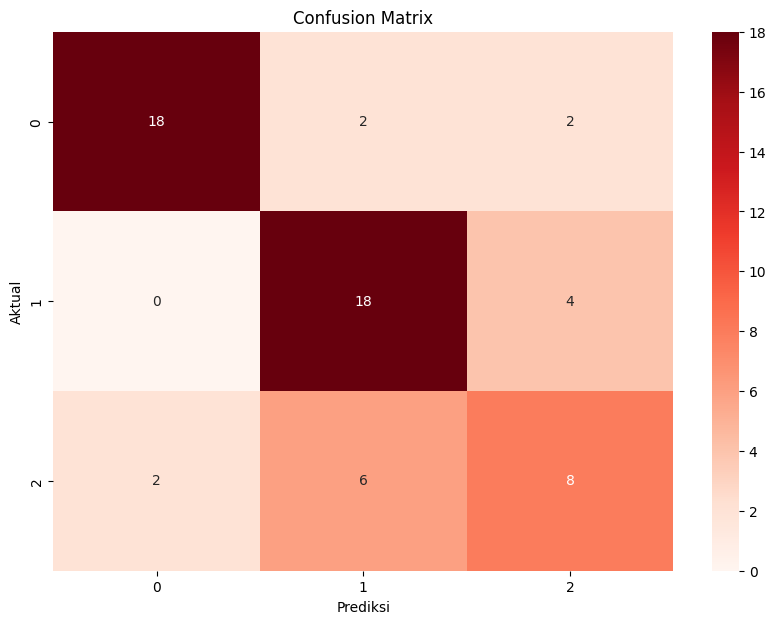

In [ ]:
# Menghitung confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Visualisasi confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Reds')
plt.xlabel('Prediksi')
plt.ylabel('Aktual')
plt.title('Confusion Matrix')
plt.show()

### Eksperiment dengan teknik bag of word 2-grams

In [ ]:
two_grams = []
for doc_tokens in tokenized_docs:
    two_grams.extend(ngrams(doc_tokens, 2))

print("\nBag of Words (2-grams):")
print(Counter(two_grams))


Bag of Words (2-grams):
Counter({('film', 'horor'): 211, ('horor', 'indonesia'): 144, ('nonton', 'film'): 39, ('film', 'indonesia'): 35, ('siksa', 'kubur'): 22, ('bawa', 'agama'): 13, ('bikin', 'film'): 12, ('bagus', 'banget'): 12, ('bawa', 'bawa'): 11, ('indonesia', 'horor'): 10, ('keren', 'banget'): 10, ('banget', 'film'): 9, ('jelang', 'ajal'): 9, ('unsur', 'agama'): 9, ('review', 'film'): 9, ('abdi', 'setan'): 8, ('indonesia', 'tuh'): 8, ('indonesia', 'film'): 8, ('salah', 'film'): 8, ('indonesia', 'ga'): 7, ('iya', 'film'): 7, ('nnton', 'film'): 7, ('indonesia', 'jaman'): 7, ('film', 'film'): 6, ('joko', 'anwar'): 6, ('bikin', 'takut'): 6, ('nonton', 'horor'): 6, ('indonesia', 'bikin'): 5, ('banget', 'horor'): 5, ('suka', 'horor'): 5, ('horor', 'film'): 5, ('suka', 'film'): 5, ('horor', 'horor'): 5, ('film', 'genre'): 5, ('genre', 'horor'): 5, ('indonesia', 'iya'): 5, ('film', 'horror'): 5, ('orang', 'indonesia'): 5, ('desa', 'tari'): 5, ('indonesia', 'suka'): 5, ('nonton', 'siks

#### pelatihan model

In [ ]:
bow_2 = CountVectorizer(ngram_range=(2, 2)).fit_transform(df["cleantext"])

X_train, X_test, y_train, y_test = train_test_split(bow_2, y, test_size=0.2, random_state=42)

# Pelatihan Model Naive Bayes
model = DecisionTreeClassifier(random_state=42)
model.fit(X_train, y_train)

# Evaluasi Model
y_pred = model.predict(X_test)
print("Classification Report:")
print(classification_report(y_test, y_pred))

Classification Report:
              precision    recall  f1-score   support

     Positif       0.70      0.64      0.67        22
     negatif       0.68      0.68      0.68        22
      netral       0.33      0.38      0.35        16

    accuracy                           0.58        60
   macro avg       0.57      0.56      0.57        60
weighted avg       0.60      0.58      0.59        60



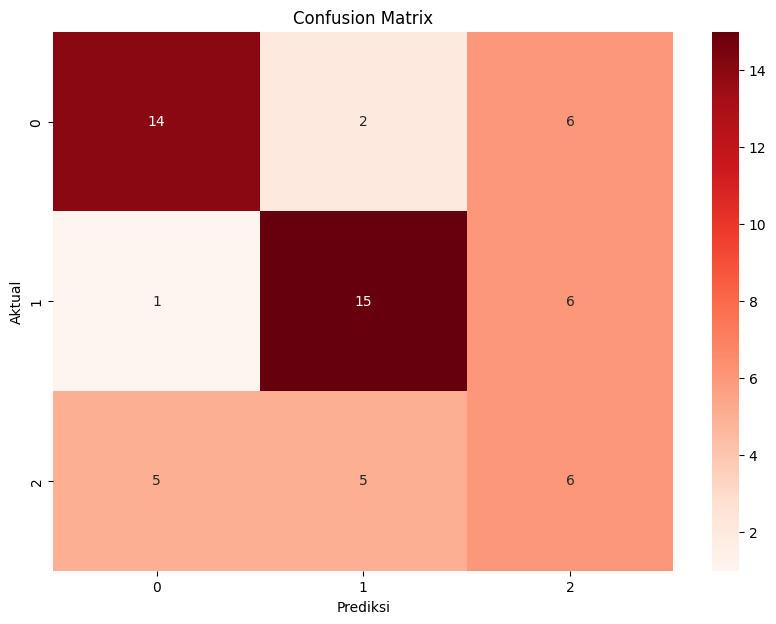

In [ ]:
# Menghitung confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Visualisasi confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Reds')
plt.xlabel('Prediksi')
plt.ylabel('Aktual')
plt.title('Confusion Matrix')
plt.show()

### Eksperiment dengan teknik bag of word 3-grams

In [ ]:
three_grams = []
for doc_tokens in tokenized_docs:
    three_grams.extend(ngrams(doc_tokens, 3))

print("\nBag of Words (3-grams):")
print(Counter(three_grams))


Bag of Words (3-grams):
Counter({('film', 'horor', 'indonesia'): 130, ('nonton', 'film', 'horor'): 28, ('film', 'indonesia', 'horor'): 10, ('bawa', 'bawa', 'agama'): 9, ('iya', 'film', 'horor'): 7, ('banget', 'film', 'horor'): 7, ('horor', 'indonesia', 'jaman'): 7, ('bikin', 'film', 'horor'): 6, ('salah', 'film', 'horor'): 6, ('nnton', 'film', 'horor'): 5, ('film', 'film', 'horor'): 5, ('nonton', 'film', 'indonesia'): 5, ('nonton', 'siksa', 'kubur'): 5, ('film', 'siksa', 'kubur'): 5, ('film', 'indonesia', 'ga'): 4, ('horor', 'indonesia', 'bikin'): 4, ('suka', 'film', 'horor'): 4, ('indonesia', 'film', 'horor'): 4, ('nonton', 'horor', 'indonesia'): 4, ('film', 'mukim', 'setan'): 4, ('horor', 'bawa', 'bawa'): 3, ('deh', 'film', 'horor'): 3, ('horor', 'indonesia', 'ga'): 3, ('kaya', 'film', 'horor'): 3, ('horor', 'indonesia', 'tuh'): 3, ('indonesia', 'jaman', 'film'): 3, ('film', 'horor', 'horor'): 3, ('bikin', 'orang', 'takut'): 3, ('ga', 'nonton', 'film'): 3, ('horor', 'indonesia', 'iy

#### pelatihan model

In [ ]:
bow_3 = CountVectorizer(ngram_range=(3, 3)).fit_transform(df["cleantext"])

X_train, X_test, y_train, y_test = train_test_split(bow_2, y, test_size=0.2, random_state=42)

# Pelatihan Model Naive Bayes
model = DecisionTreeClassifier(random_state=42)
model.fit(X_train, y_train)

# Evaluasi Model
y_pred = model.predict(X_test)
print("Classification Report:")
print(classification_report(y_test, y_pred))

Classification Report:
              precision    recall  f1-score   support

     Positif       0.70      0.64      0.67        22
     negatif       0.68      0.68      0.68        22
      netral       0.33      0.38      0.35        16

    accuracy                           0.58        60
   macro avg       0.57      0.56      0.57        60
weighted avg       0.60      0.58      0.59        60



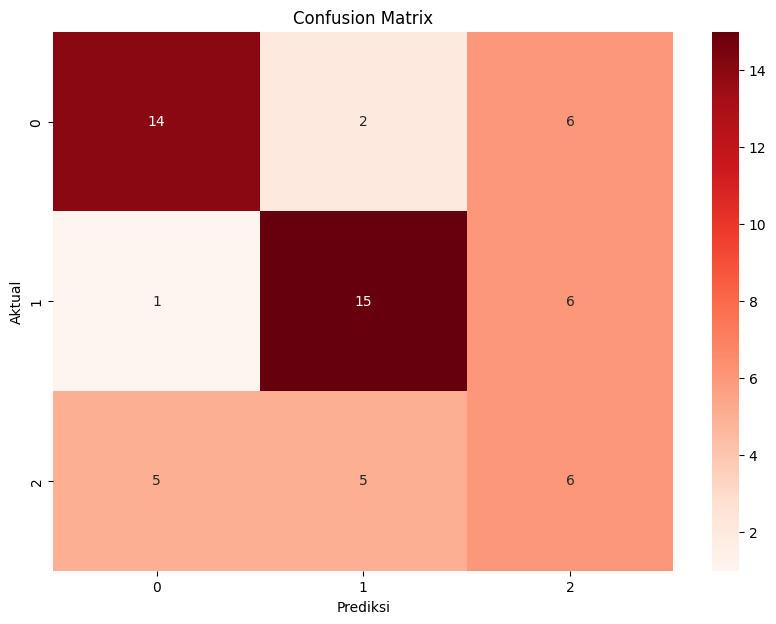

In [ ]:
# Menghitung confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Visualisasi confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Reds')
plt.xlabel('Prediksi')
plt.ylabel('Aktual')
plt.title('Confusion Matrix')
plt.show()

### Eksperiment dengan tf-idf

In [ ]:
vectorizer = TfidfVectorizer()
X_tfidf = vectorizer.fit_transform(df["cleantext"])

# Mengonversi hasil TF-IDF ke dalam representasi DataFrame
tfidf_df = pd.DataFrame(X_tfidf.toarray(), columns=vectorizer.get_feature_names_out())

tfidf_df

,abang,abdi,abis,absurd,adat,adegan,adil,agam,agama,air,...,wedi,wilona,wish,woi,wow,ya,yaaa,you,youtube,yuk
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.169761,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
295,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
296,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
297,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
298,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


#### pelatihan model

In [ ]:
vectorizer = TfidfVectorizer()
X_tfidf = vectorizer.fit_transform(df["cleantext"])

X_train, X_test, y_train, y_test = train_test_split(X_tfidf, df['sentimen'], test_size=0.2, random_state=42)

# Pelatihan Model Naive Bayes
model = DecisionTreeClassifier(random_state=42)
model.fit(X_train, y_train)

# Evaluasi Model
y_pred = model.predict(X_test)
print("Classification Report:")
print(classification_report(y_test, y_pred))

Classification Report:
              precision    recall  f1-score   support

     Positif       0.68      0.59      0.63        22
     negatif       0.71      0.68      0.70        22
      netral       0.45      0.56      0.50        16

    accuracy                           0.62        60
   macro avg       0.62      0.61      0.61        60
weighted avg       0.63      0.62      0.62        60



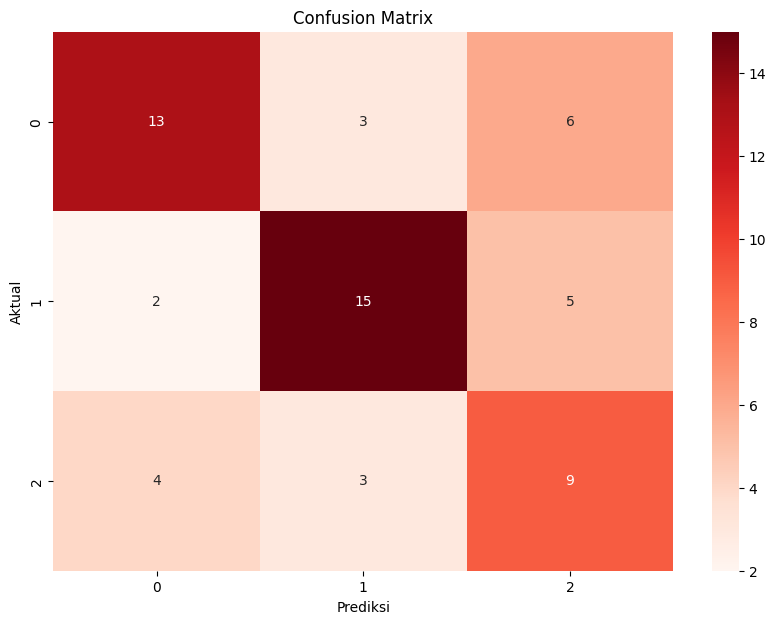

In [ ]:
# Menghitung confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Visualisasi confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Reds')
plt.xlabel('Prediksi')
plt.ylabel('Aktual')
plt.title('Confusion Matrix')
plt.show()

### Eksperiment dengan Word2Vec

In [ ]:
sentences = [sentence.split() for sentence in df['cleantext']]

# Melatih model Word2Vec
word2vec_model = Word2Vec(sentences, vector_size=100, window=3, min_count=1, sg=1)

# Function to convert text to Word2Vec embeddings
def text_to_word2vec(text, model):
    words = text.split()
    embedding_matrix = np.zeros((len(words), model.vector_size))
    for i, word in enumerate(words):
        if word in model.wv:
            embedding_matrix[i] = model.wv[word]
    return np.mean(embedding_matrix, axis=0)

# Apply the function to each text in the DataFrame
df['word2vec_vector'] = df['cleantext'].apply(lambda x: text_to_word2vec(x, word2vec_model))

print("Representasi Word2Vec:")
df[['cleantext', 'word2vec_vector']]

Representasi Word2Vec:


,cleantext,word2vec_vector
0,sih film horor indonesia atur malam nya lihat ...,"[-0.015341752412496135, 0.022791487754147965, ..."
1,rumah produksi indonesia gabikin film horor ke...,"[-0.013824661486848657, 0.02227071618628023, 0..."
2,film indonesia ga horor bawa bawa agama poliga...,"[-0.011419425859847772, 0.024615690311683074, ..."
3,bicara banget film indonesia horor melulu main...,"[-0.018202211416792125, 0.03431156268925406, 0..."
4,film ga cocok horor maksa banget anjing dokume...,"[-0.014843189841485582, 0.024406958604231477, ..."
...,...,...
295,siksa kubur sukses bikin horror bikin takut sa...,"[-0.007584180111734895, 0.02175332281331066, 0..."
296,pamalidusunpocong ngeri banget dusun pocong wa...,"[-0.011124397225033205, 0.013342889352665784, ..."
297,sumpah kagum film horor bikin bagus anzaay bed...,"[-0.020029105224900624, 0.03046273629032922, 0..."
298,emang sutradara bintang jamin bikin merinding,"[-0.007404966435084741, 0.012752191163599491, ..."


In [ ]:
df["cleantext"][0]

'sih film horor indonesia atur malam nya lihat sumpah capek banget film gelap nya ga tolong'

In [ ]:
df["word2vec_vector"][0]

array([-0.01534175,  0.02279149,  0.01711651,  0.00845333,  0.02038456,
       -0.08427314,  0.02491946,  0.12990316, -0.01881489, -0.05769621,
       -0.02066176, -0.07396941, -0.00726807,  0.02044699,  0.01715336,
       -0.05013765,  0.01951906, -0.03072611, -0.00912126, -0.11047426,
        0.00911529, -0.00064507,  0.01161081, -0.05067511,  0.00467998,
       -0.0076511 , -0.06508516, -0.00403494, -0.06498306,  0.00436401,
        0.05829171,  0.00093751,  0.00936963, -0.06459617, -0.02684527,
        0.05188982,  0.02780093, -0.03803948, -0.05485603, -0.05499514,
       -0.00862444, -0.04307529, -0.0298763 ,  0.01999334,  0.03743708,
       -0.03196833, -0.03702304, -0.01471777,  0.03794295,  0.03027157,
        0.03354398, -0.04839914, -0.00486721, -0.00534919, -0.05202397,
        0.0049326 ,  0.04335049, -0.00527226, -0.03475536,  0.02622194,
       -0.00283347,  0.00561186,  0.0030915 , -0.02950714, -0.07061342,
        0.06535703,  0.01856395,  0.04235795, -0.05909716,  0.03

#### Pelatihan model

In [ ]:
# Membagi data menjadi training dan testing set
X = np.vstack(df['word2vec_vector'].values)
y = df['sentimen']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Inisialisasi Decision Tree Classifier
clf = DecisionTreeClassifier()

# Melatih model
clf.fit(X_train, y_train)

# Melakukan prediksi pada data testing
y_pred = clf.predict(X_test)

# Menampilkan hasil akurasi dan laporan klasifikasi
print("Akurasi:", accuracy_score(y_test, y_pred))
print("Laporan Klasifikasi:")
print(classification_report(y_test, y_pred))

Akurasi: 0.5333333333333333
Laporan Klasifikasi:
              precision    recall  f1-score   support

     Positif       0.57      0.55      0.56        22
     negatif       0.67      0.45      0.54        22
      netral       0.42      0.62      0.50        16

    accuracy                           0.53        60
   macro avg       0.55      0.54      0.53        60
weighted avg       0.57      0.53      0.54        60



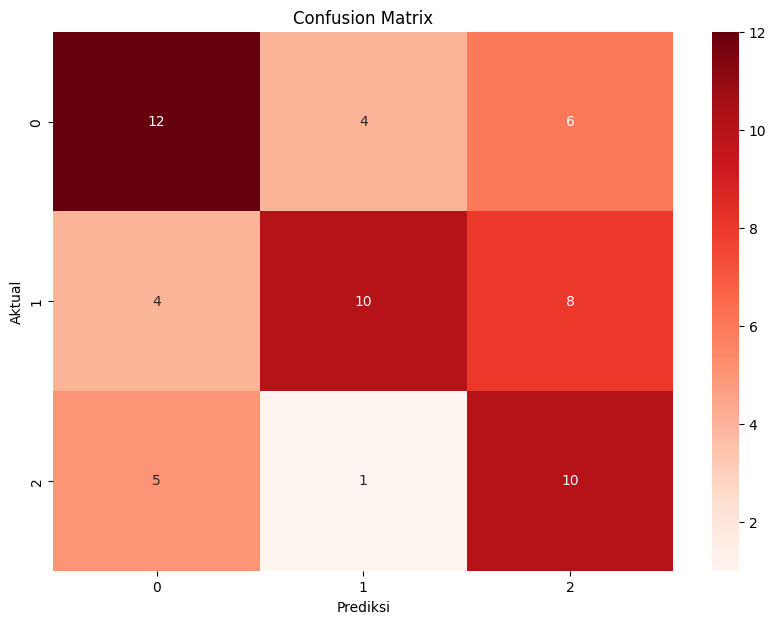

In [ ]:
# Menghitung confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Visualisasi confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Reds')
plt.xlabel('Prediksi')
plt.ylabel('Aktual')
plt.title('Confusion Matrix')
plt.show()